# **Activity Agent**

The activity agent will be responsible for predicting the user's activity for a given day. It will produce activity probabilities for the given user and the given day on an hourly level. These hourly activity probabilities will be processed by the subsequent recommendation agent to determine for which hours our framework should make recommendations. As input the activity agent receives the prepared data from the preparation agent.

We will define an activity agent class, add necessary functions to the agent, explain each step and build our final activity agent pipeline. A complete activity agent class definition will be available in the appendix to this notebook.

## **1. Preparing the Environment**

### **1.1 Loading the Libraries and the Data**

Steps to set up the environment for the activity agent include loading the necessary libraries, data and preceding agents.


In [4]:
import pandas as pd
import numpy as np
import os
dir = 'D:/Master BWL HU/3. Semester/Seminar Information Systems/Seminar-Information-Systems-main'
os.chdir(dir)

from helper_functions import Helper
from PreparationAgent import Preparation_Agent
import pandas as pd

helper = Helper()

dbfile  = "D:/Master BWL HU/3. Semester/Seminar Information Systems/Seminar-Information-Systems-main/home-assistant_Chris.db"


In [5]:
import pandas as pd
import numpy as np
import os
dir = '/Users/sofyakonchakova/Desktop/HU_Berlin/SIS/codes/'
os.chdir(dir)

from helper_functions import Helper
from PreparationAgent import Preparation_Agent
import pandas as pd

helper = Helper()

dbfile  = "/Users/sofyakonchakova/Desktop/home-assistant_Chris.db"

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: '/Users/sofyakonchakova/Desktop/HU_Berlin/SIS/codes/'

In [6]:
def export_sql2(file):
    import sqlite3
    import pandas as pd  
    with sqlite3.connect(file) as con:
        cur = con.cursor()
        cur.execute("SELECT * FROM states")
        states = cur.fetchall()
    from_states_db = []
    for result in states:
        result = list(result)
        from_states_db.append(result)
    columns = ["state_id","entity_id","state","attributes","event_id","last_changed","last_updated","old_state_id","attributes_id","context_id","context_user_id","context_parent_id","origin_idx"]
    states_df = pd.DataFrame(from_states_db, columns = columns)

    with sqlite3.connect(file) as con:
        cur = con.cursor()
        cur.execute("SELECT * FROM state_attributes")
        state_attributes = cur.fetchall()
    from_state_attributes_db = []
    for result in state_attributes:
        result = list(result)
        from_state_attributes_db.append(result)
    columns = ["attributes_id","hash","shared_attributes"]
    state_attributes_df = pd.DataFrame(from_state_attributes_db, columns = columns)

    output = pd.merge(states_df, state_attributes_df, how= "left", on = 'attributes_id')
    return output

In [7]:
# load household data
prep = Preparation_Agent(export_sql2(dbfile))

### **1.2 Calling the Preparation Agent**

To receive the necessary input for the activity agent, we will call the activity pipeline function of the preparation agent. We will specify the input data and the necessary configurations. As a quick validation that the preparation pipeline worked properly, we will plot the hourly activity of the household.

The current input data includes only a few time features and activity lags. However, our agent architecture allows to expand the inputs to the activity agent to further features or further data sources (e.g. whether data). For the purpose of demonstrating the functionality of our framework, we only use the inputs from the prepared REFIT data. 


In [8]:
truncation_params = {
    'features': 'all', 
    'factor': 1.5, 
    'verbose': 1
}

scale_params = {
    'features': 'all', 
    'kind': 'MinMax', 
    'verbose': 1
}

aggregate_params = {
    'resample_param': '60T'
}
#update with active appliances attributes_ids
activity_params = {
    'active_appliances': [573,579,603,605],
    'threshold': .15
}

time_params = {
    'features': ['hour', 'day_name']
}

activity_lag_params = {
    'features': ['activity'],
    'lags': [24, 48, 72]
}

activity_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate': aggregate_params,
    'activity': activity_params,
    'time': time_params,
    'activity_lag': activity_lag_params
}

In [9]:
prep.pipeline_activity

<bound method Preparation_Agent.pipeline_activity of <PreparationAgent.Preparation_Agent object at 0x0000023764600760>>

In [10]:
# calling the preparation pipelin
db = export_sql2(dbfile)
import pandas as pd
df = prep.pipeline_activity(db, activity_pipe_params)
df

[outlier truncation: 573]: 100%|█████████████████████████████████████████████████████████████| 651/651 [00:00<?, ?it/s]


[outlier truncation: 573]: 0 outliers were truncated.




[outlier truncation: 579]: 100%|█████████████████████████████████████████████████████████████| 302/302 [00:00<?, ?it/s]


[outlier truncation: 579]: 0 outliers were truncated.




[outlier truncation: 603]: 0it [00:00, ?it/s]


[outlier truncation: 603]: 0 outliers were truncated.




[outlier truncation: 605]: 0it [00:00, ?it/s]


[outlier truncation: 605]: 0 outliers were truncated.


[MinMaxScaler] Finished scaling the data.


,activity,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,,
2022-11-21 17:00:00,1,17,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 18:00:00,1,18,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 19:00:00,0,19,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 20:00:00,1,20,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 21:00:00,0,21,NaN,NaN,NaN,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 13:00:00,1,13,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 14:00:00,1,14,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 15:00:00,0,15,0.0,0.0,0.0,0,0,0,0,0,1


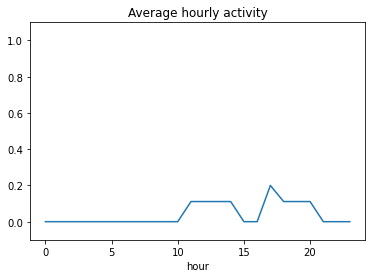

In [11]:
import matplotlib.pyplot as plt

df.groupby(by='hour').mean()['activity'].plot();
plt.title('Average hourly activity')
plt.ylim(-0.1, 1.1);


## **2. Creating the Activity Agent**

In [12]:
class Activity_Agent:

    def __init__(self, activity_input_df):
        self.input = activity_input_df

### **2.1 Train Test Split**

As our recommendation framework will provide recommendations for a given day, our activity agent must be able to provide activity predictions for each day. However, for each day to be predicted we are only allowed to use information from the past to prevent leakage. Therefore, we will create a custom train test split function to meet the time series requirements. 

Our train test split function will enable us to conveniently split our data in the train and test data sets for each day to be predicted while allowing for further configurations of the split (i.e. size of the train and test data sets).

**X_test**

In [13]:
def get_Xtest(self, df, date, time_delta='all', target='activity'):
    import pandas as pd
    from helper_functions import Helper

    helper = Helper()
    
    if time_delta == 'all':
        output = df.loc[pd.to_datetime(date):, df.columns != target]
    else:
        df = helper.get_timespan(df, date, time_delta)
        output = df.loc[:, df.columns != target]
    return output

# add to Activity agent
setattr(Activity_Agent, 'get_Xtest', get_Xtest)
del get_Xtest

In [14]:
date = '2022-11-21'
activity = Activity_Agent(df)
X_test = activity.get_Xtest(df, date)
X_test

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,
2022-11-21 17:00:00,17,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 18:00:00,18,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 19:00:00,19,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 20:00:00,20,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 21:00:00,21,NaN,NaN,NaN,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2022-11-30 13:00:00,13,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 14:00:00,14,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 15:00:00,15,0.0,0.0,0.0,0,0,0,0,0,1


In [15]:
date = '2022-11-21'
activity = Activity_Agent(df)
time_delta = {'days': 1, 'seconds': -1}
X_test = activity.get_Xtest(df, date, time_delta=time_delta)
X_test

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,
2022-11-21 17:00:00,17,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 18:00:00,18,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 19:00:00,19,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 20:00:00,20,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 21:00:00,21,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 22:00:00,22,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 23:00:00,23,NaN,NaN,NaN,1,0,0,0,0,0


In [16]:
date = '2022-11-21'
activity = Activity_Agent(df)
time_delta = {'days': 30, 'seconds': -1}
X_test = activity.get_Xtest(df, date, time_delta=time_delta)
X_test

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,
2022-11-21 17:00:00,17,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 18:00:00,18,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 19:00:00,19,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 20:00:00,20,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 21:00:00,21,NaN,NaN,NaN,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2022-11-30 13:00:00,13,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 14:00:00,14,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 15:00:00,15,0.0,0.0,0.0,0,0,0,0,0,1


**y_test**

In [17]:
def get_ytest(self, df, date, time_delta='all', target='activity'):
    import pandas as pd
    from helper_functions import Helper

    helper = Helper()
    
    if time_delta == 'all':
        output = df.loc[pd.to_datetime(date):, target]
    else:
        output = helper.get_timespan(df, date, time_delta)[target]
    return output

# add to Activity agent
setattr(Activity_Agent, 'get_ytest', get_ytest)
del get_ytest

In [18]:
date = '2022-11-21'
activity = Activity_Agent(df)
y_test = activity.get_ytest(df, date)
y_test

last_updated
2022-11-21 17:00:00    1
2022-11-21 18:00:00    1
2022-11-21 19:00:00    0
2022-11-21 20:00:00    1
2022-11-21 21:00:00    0
                      ..
2022-11-30 13:00:00    1
2022-11-30 14:00:00    1
2022-11-30 15:00:00    0
2022-11-30 16:00:00    0
2022-11-30 17:00:00    1
Freq: 60T, Name: activity, Length: 217, dtype: int32

In [19]:
date = '2022-11-22'

activity = Activity_Agent(df)
time_delta = {'days': 7, 'seconds': -1}

y_test = activity.get_ytest(df, date, time_delta=time_delta)
y_test

last_updated
2022-11-22 00:00:00    0
2022-11-22 01:00:00    0
2022-11-22 02:00:00    0
2022-11-22 03:00:00    0
2022-11-22 04:00:00    0
                      ..
2022-11-28 19:00:00    0
2022-11-28 20:00:00    0
2022-11-28 21:00:00    0
2022-11-28 22:00:00    0
2022-11-28 23:00:00    0
Freq: 60T, Name: activity, Length: 168, dtype: int32

**X_train**

In [20]:
# start = int (e.g. -100) --> 100 days before the day to be predicted will represent the train data
def get_Xtrain(self, df, date, start=-30, target='activity'):
    import pandas as pd

    if type(start) == int:
        start = pd.to_datetime(date) + pd.Timedelta(days= start)
        start = pd.to_datetime('2013-11-01') if start < pd.to_datetime('2013-11-01') else start
    else:
        start = pd.to_datetime(start)
    end = pd.to_datetime(date) + pd.Timedelta(seconds=-1)
    return df.loc[start:end, df.columns != target]

# add to Activity agent
setattr(Activity_Agent, 'get_Xtrain', get_Xtrain)
del get_Xtrain

In [21]:
date = '2022-11-30'

activity = Activity_Agent(df)
X_train = activity.get_Xtrain(df, date)
X_train

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,
2022-11-21 17:00:00,17,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 18:00:00,18,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 19:00:00,19,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 20:00:00,20,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 21:00:00,21,NaN,NaN,NaN,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2022-11-29 19:00:00,19,0.0,0.0,0.0,0,0,0,0,1,0
2022-11-29 20:00:00,20,0.0,0.0,0.0,0,0,0,0,1,0
2022-11-29 21:00:00,21,0.0,0.0,0.0,0,0,0,0,1,0


In [22]:
date = '2022-11-22'

activity = Activity_Agent(df)
X_train = activity.get_Xtrain(df, date, start=-1)
X_train

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,
2022-11-21 17:00:00,17,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 18:00:00,18,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 19:00:00,19,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 20:00:00,20,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 21:00:00,21,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 22:00:00,22,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 23:00:00,23,NaN,NaN,NaN,1,0,0,0,0,0


In [23]:
date = '2022-11-22'

activity = Activity_Agent(df)
X_train = activity.get_Xtrain(df, date, start=-10)
X_train

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,
2022-11-21 17:00:00,17,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 18:00:00,18,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 19:00:00,19,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 20:00:00,20,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 21:00:00,21,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 22:00:00,22,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 23:00:00,23,NaN,NaN,NaN,1,0,0,0,0,0


In [24]:
date = '2022-11-30'

activity = Activity_Agent(df)
X_train = activity.get_Xtrain(df, date, start=-10)
X_train

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,
2022-11-21 17:00:00,17,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 18:00:00,18,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 19:00:00,19,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 20:00:00,20,NaN,NaN,NaN,1,0,0,0,0,0
2022-11-21 21:00:00,21,NaN,NaN,NaN,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2022-11-29 19:00:00,19,0.0,0.0,0.0,0,0,0,0,1,0
2022-11-29 20:00:00,20,0.0,0.0,0.0,0,0,0,0,1,0
2022-11-29 21:00:00,21,0.0,0.0,0.0,0,0,0,0,1,0


**y_train**

In [25]:
def get_ytrain(self, df, date, start=-30, target='activity'):
    import pandas as pd

    if type(start) == int:
        start = pd.to_datetime(date) + pd.Timedelta(days= start)
        start = pd.to_datetime('2022-11-20') if start < pd.to_datetime('2022-11-20') else start
    else:
        start = pd.to_datetime(start)
    end = pd.to_datetime(date) + pd.Timedelta(seconds=-1)
    return df.loc[start:end, target]

# add to Activity agent
setattr(Activity_Agent, 'get_ytrain', get_ytrain)
del get_ytrain

In [26]:
date = '2022-11-30'
activity = Activity_Agent(df)
y_train = activity.get_ytrain(df, date)
y_train

last_updated
2022-11-21 17:00:00    1
2022-11-21 18:00:00    1
2022-11-21 19:00:00    0
2022-11-21 20:00:00    1
2022-11-21 21:00:00    0
                      ..
2022-11-29 19:00:00    1
2022-11-29 20:00:00    0
2022-11-29 21:00:00    0
2022-11-29 22:00:00    0
2022-11-29 23:00:00    0
Freq: 60T, Name: activity, Length: 199, dtype: int32

In [27]:
date = '2022-11-22'
activity = Activity_Agent(df)
y_train = activity.get_ytrain(df, date, start=-1)
y_train

last_updated
2022-11-21 17:00:00    1
2022-11-21 18:00:00    1
2022-11-21 19:00:00    0
2022-11-21 20:00:00    1
2022-11-21 21:00:00    0
2022-11-21 22:00:00    0
2022-11-21 23:00:00    0
Freq: 60T, Name: activity, dtype: int32

In [28]:
date = '2022-11-30'
activity = Activity_Agent(df)
y_train = activity.get_ytrain(df, date, start=-10)
y_train

last_updated
2022-11-21 17:00:00    1
2022-11-21 18:00:00    1
2022-11-21 19:00:00    0
2022-11-21 20:00:00    1
2022-11-21 21:00:00    0
                      ..
2022-11-29 19:00:00    1
2022-11-29 20:00:00    0
2022-11-29 21:00:00    0
2022-11-29 22:00:00    0
2022-11-29 23:00:00    0
Freq: 60T, Name: activity, Length: 199, dtype: int32

In [29]:
date = '2022-11-30'
activity = Activity_Agent(df)
y_train = activity.get_ytrain(df, date, start=-9999)
y_train

last_updated
2022-11-21 17:00:00    1
2022-11-21 18:00:00    1
2022-11-21 19:00:00    0
2022-11-21 20:00:00    1
2022-11-21 21:00:00    0
                      ..
2022-11-29 19:00:00    1
2022-11-29 20:00:00    0
2022-11-29 21:00:00    0
2022-11-29 22:00:00    0
2022-11-29 23:00:00    0
Freq: 60T, Name: activity, Length: 199, dtype: int32

**train_test_split**

<font color = 'red'> Without filling NAs, I cannot procede further. Is it okay? </font>

In [30]:
def train_test_split(self, df, date, train_start='2013-11-01', test_delta='all', target='activity'):
    X_train = self.get_Xtrain(df, date, start=train_start, target=target)
    y_train = self.get_ytrain(df, date, start=train_start, target=target)
    X_test = self.get_Xtest(df, date, time_delta=test_delta, target=target)
    y_test = self.get_ytest(df, date, time_delta=test_delta, target=target)
    X_test = X_test.fillna(0)
    X_train = X_train.fillna(0)
    y_test = y_test.fillna(0)
    y_train = y_train.fillna(0)
    return X_train, y_train, X_test, y_test

# add to Activity agent
setattr(Activity_Agent, 'train_test_split', train_test_split)
del train_test_split    

In [31]:
date = '2022-11-30'
activity = Activity_Agent(df)
X_train, y_train, X_test, y_test = activity.train_test_split(df, date)
df.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((217, 11), (199, 10), (199,), (18, 10), (18,))

In [32]:
date = '2022-11-30'
activity = Activity_Agent(df)
X_train, y_train, X_test, y_test = activity.train_test_split(df, date, train_start=-10, test_delta={'days': 10, 'seconds':-1})
df.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((217, 11), (199, 10), (199,), (18, 10), (18,))

In [33]:
date = '2022-11-30'
activity = Activity_Agent(df)
X_train, y_train, X_test, y_test = activity.train_test_split(df, date, test_delta={'days': 1, 'seconds':-1})
df.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((217, 11), (199, 10), (199,), (18, 10), (18,))

In [34]:
X_train

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,
2022-11-21 17:00:00,17,0.0,0.0,0.0,1,0,0,0,0,0
2022-11-21 18:00:00,18,0.0,0.0,0.0,1,0,0,0,0,0
2022-11-21 19:00:00,19,0.0,0.0,0.0,1,0,0,0,0,0
2022-11-21 20:00:00,20,0.0,0.0,0.0,1,0,0,0,0,0
2022-11-21 21:00:00,21,0.0,0.0,0.0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2022-11-29 19:00:00,19,0.0,0.0,0.0,0,0,0,0,1,0
2022-11-29 20:00:00,20,0.0,0.0,0.0,0,0,0,0,1,0
2022-11-29 21:00:00,21,0.0,0.0,0.0,0,0,0,0,1,0


In [35]:
X_test

,hour,activity_lag_24,activity_lag_48,activity_lag_72,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
last_updated,,,,,,,,,,
2022-11-30 00:00:00,0,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 01:00:00,1,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 02:00:00,2,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 03:00:00,3,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 04:00:00,4,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 05:00:00,5,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 06:00:00,6,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 07:00:00,7,0.0,0.0,0.0,0,0,0,0,0,1
2022-11-30 08:00:00,8,0.0,0.0,0.0,0,0,0,0,0,1


In [36]:
y_train

last_updated
2022-11-21 17:00:00    1
2022-11-21 18:00:00    1
2022-11-21 19:00:00    0
2022-11-21 20:00:00    1
2022-11-21 21:00:00    0
                      ..
2022-11-29 19:00:00    1
2022-11-29 20:00:00    0
2022-11-29 21:00:00    0
2022-11-29 22:00:00    0
2022-11-29 23:00:00    0
Freq: 60T, Name: activity, Length: 199, dtype: int32

In [37]:
y_test

last_updated
2022-11-30 00:00:00    0
2022-11-30 01:00:00    0
2022-11-30 02:00:00    0
2022-11-30 03:00:00    0
2022-11-30 04:00:00    0
2022-11-30 05:00:00    0
2022-11-30 06:00:00    0
2022-11-30 07:00:00    0
2022-11-30 08:00:00    0
2022-11-30 09:00:00    0
2022-11-30 10:00:00    0
2022-11-30 11:00:00    1
2022-11-30 12:00:00    1
2022-11-30 13:00:00    1
2022-11-30 14:00:00    1
2022-11-30 15:00:00    0
2022-11-30 16:00:00    0
2022-11-30 17:00:00    1
Freq: 60T, Name: activity, dtype: int32

### **2.2 Building Models**

Within this section, we will demonstrate how different models for predicting the user activity could be added to the activity agent. For this notebook, we chose to implement a pretty simple logistic regression using the statsmodel api which already provides promising results. 

The functionality of the activity agent will include building models, fitting models and predicting the user’s activity.


#### Not sure where to include the libraries

In [38]:
import numpy as np
import pandas
import sklearn
import statsmodels
from interpret.glassbox.ebm.ebm import ExplainableBoostingClassifier     
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost
import statsmodels.api
import datetime

C:\Users\chris\anaconda3\envs\recomm\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [39]:
def fit_Logit(self, X, y, max_iter=100):
    return LogisticRegression(random_state=0, max_iter=max_iter).fit(X, y)

def fit_knn(self, X, y, n_neighbors=10, leaf_size=30):
    return KNeighborsClassifier(n_neighbors=n_neighbors, leaf_size=leaf_size, algorithm="auto", n_jobs=-1).fit(X, y)

def fit_random_forest(self, X, y, max_depth=10, n_estimators=500, max_features="sqrt"):
    return RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, max_features=max_features, n_jobs=-1).fit(X, y)

def fit_ADA(self, X, y, learning_rate=0.1, n_estimators=100):
    return AdaBoostClassifier(learning_rate=learning_rate, n_estimators=n_estimators).fit(X, y)

def fit_XGB(self, X, y, learning_rate=0.1, max_depth=6, reg_lambda=1, reg_alpha=0):
    return xgboost.XGBClassifier(verbosity=0, use_label_encoder=False, learning_rate=learning_rate, max_depth=max_depth, reg_lambda=reg_lambda, reg_alpha=reg_alpha).fit(X, y)

def fit_EBM(self, X, y): 
    return ExplainableBoostingClassifier().fit(X,y)

def fit_smLogit(self, X, y):
    return statsmodels.api.Logit(y, X).fit(disp=False)

# add to Activity agent
setattr(Activity_Agent, 'fit_Logit', fit_Logit)
del fit_Logit 
setattr(Activity_Agent, 'fit_knn', fit_knn)
del fit_knn 
setattr(Activity_Agent, 'fit_random_forest', fit_random_forest)
del fit_random_forest 
setattr(Activity_Agent, 'fit_ADA', fit_ADA)
del fit_ADA 
setattr(Activity_Agent, 'fit_XGB', fit_XGB)
del fit_XGB 
setattr(Activity_Agent, 'fit_EBM', fit_EBM)
del fit_EBM 
setattr(Activity_Agent, 'fit_smLogit', fit_smLogit)
del fit_smLogit 

Why did you use statsmodels.api as sm instead of LogisticRegression? any advantages?
Logit is 

In [40]:
def fit(self, X, y, model_type, **args):
    model = None
    if model_type == "logit":
        model = self.fit_Logit(X, y, **args)
    elif model_type == "ada":
        model = self.fit_ADA(X, y, **args)
    elif model_type == "knn":
        model = self.fit_knn(X, y, **args)
    elif model_type == "random forest":
        model = self.fit_random_forest(X, y, **args)
    elif model_type == "xgboost":
        model = self.fit_XGB(X, y, **args)
    elif model_type == "ebm":
        model = self.fit_EBM(X,y, **args)
    elif model_type == "logit_sm":
        model = self.fit_smLogit(X, y)
    else:
        raise InputError("Unknown model type.")
    return model

# add to Activity agent
setattr(Activity_Agent, 'fit', fit)
del fit

In [41]:
activity = Activity_Agent(df)
model = activity.fit(X_train, y_train, 'logit_sm')
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:               activity   No. Observations:                  199
Model:                          Logit   Df Residuals:                      189
Method:                           MLE   Df Model:                            9
Date:                Thu, 29 Dec 2022   Pseudo R-squ.:                 -0.2966
Time:                        12:46:01   Log-Likelihood:                -25.397
converged:                      False   LL-Null:                       -19.588
Covariance Type:            nonrobust   LLR p-value:                     1.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
hour                  -0.1165      0.041     -2.862      0.004      -0.196      -0.037
activity_lag_24      -18.5990   7.34e+04     -0.000      1.000   -1.44e+05    1.44e+05
activity_lag_48     

C:\Users\chris\anaconda3\envs\recomm\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
def predict(self, model, X):
    
    if type(model) == sklearn.linear_model.LogisticRegression:
        y_hat = model.predict_proba(X)[:,1]

    elif type(model) == sklearn.neighbors._classification.KNeighborsClassifier:
        y_hat = model.predict_proba(X)[:,1]

    elif type(model) == sklearn.ensemble._forest.RandomForestClassifier:
        y_hat = model.predict_proba(X)[:,1]

    elif type(model) ==  sklearn.ensemble._weight_boosting.AdaBoostClassifier:
        y_hat = model.predict_proba(X)[:,1]

    elif type(model) == xgboost.sklearn.XGBClassifier:
        y_hat = model.predict_proba(X)[:,1]

    elif type(model) == ExplainableBoostingClassifier:
        y_hat = model.predict_proba(X)[:,1]
    
    elif type(model) == statsmodels.discrete.discrete_model.BinaryResultsWrapper:
        y_hat = model.predict(X)
        
    else:
        raise InputError("Unknown model type.")

    y_hat = pd.Series(y_hat, index=X.index)

    return y_hat

# add to Activity agent
setattr(Activity_Agent, 'predict', predict)
del predict

### **2.3 Model Evaluation**

A drawback to our approach is that we are not able to apply conventional model evaluation techniques to our model. We will train our model for each day to account for newly available information. Hence, we have different train and test sets for each day and for each day different performance metric based on the respective data sets. Therefore, we created our own evaluation function. 

Our evaluation function will build a model, fit the model and predict the target for each day for a given prediction period. For each day and fitted model it will calculate a performance metric on the train data. We chose the Area Under the Receiver Operating Characteristic Curve (AUC) as performance metric for our binary classification task. As in our case the test data is only the current date to be predicted (i.e. 24 data cases in the test data, one for each hour of the day), calculating the AUC on the test date immediately would lead to a high volatility in the test AUC per day to be predicted. Therefore, we calculate the test AUC over the activity probabilities of all days after all days have been predicted. To summarize the train AUC in one score, we apply an average over all calculated train AUC scores.

In [43]:
def auc(self, y_true, y_hat):
    import sklearn.metrics
    return sklearn.metrics.roc_auc_score(y_true, y_hat)

# add to Activity agent
setattr(Activity_Agent, 'auc', auc)
del auc

In [44]:
activity = Activity_Agent(df)
model = activity.fit(X_train, y_train, 'xgboost')

C:\Users\chris\anaconda3\envs\recomm\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [45]:
y_hat = activity.predict(model, X_test)

In [46]:
roc_auc_score = activity.auc(y_test, y_hat)

In [47]:
roc_auc_score

0.6

In [48]:
def evaluate(
        self, df, split_params, model_type, predict_start="2013-11-30", predict_end=-1, return_errors=False,
        xai=False, weather_sel=False, **args
    ):
    import pandas as pd
    import numpy as np
    from tqdm import tqdm

    dates = (
        pd.DataFrame(df.index)
        .set_index(df.index)["last_updated"]
        .apply(lambda date: str(date)[:10])
        .drop_duplicates()
    )
    predict_start = pd.to_datetime(predict_start)
    predict_end = (
        pd.to_datetime(dates.iloc[predict_end])
        if type(predict_end) == int
        else pd.to_datetime(predict_end)
     )
    dates = dates.loc[predict_start:predict_end]
    y_true = []
    y_hat_train = {}
    y_hat_test = []
    y_hat_lime = []
    y_hat_shap = []
    auc_train_dict = {}
    auc_test = []
    xai_time_lime = []
    xai_time_shap = []

    predictions_list = []

    if weather_sel:
        print("Crawl weather data....")
        # Add Weather
        ################################
        from meteostat import Point, Hourly
        from datetime import datetime

        lough = Point(52.766593, -1.223511)
        time = df.index.to_series(name="time").tolist()
        weather = Hourly(lough, time[0], time[len(df) - 1])
        weather = weather.fetch()

        from sklearn.impute import KNNImputer
        import numpy as np

        headers = weather.columns.values

        empty_train_columns = []
        for col in weather.columns.values:
            if sum(weather[col].isnull()) == weather.shape[0]:
                empty_train_columns.append(col)
        headers = np.setdiff1d(headers, empty_train_columns)

        imputer = KNNImputer(missing_values=np.nan, n_neighbors=7, weights="distance")
        weather = imputer.fit_transform(weather)
        scaler = MinMaxScaler()
        weather = scaler.fit_transform(weather)
        weather = pd.DataFrame(weather)
        weather["time"] = time[0:len(weather)]
        df["time"] = time

        weather.columns = np.append(headers, "time")

        df = pd.merge(df, weather, how="right", on="time")
        df = df.set_index("time")
        ################################
    if not xai:
        for date in tqdm(dates):
            errors = {}
            try:
                X_train, y_train, X_test, y_test = self.train_test_split(
                    df, date, **split_params
                )

                # fit model
                model = self.fit(X_train, y_train, model_type, **args)

                y_hat_train.update({date: self.predict(model, X_train)})
                y_hat_test += list(self.predict(model, X_test))

                # evaluate train data
                auc_train_dict.update(
                    {date: self.auc(y_train, list(y_hat_train.values())[-1])}
                )
                y_true += list(y_test)

            except Exception as e:
                errors[date] = e
    else:
        print('The explainability approaches in the Activity Agent are being evaluated for model: ' + str(model_type))
        print('Start evaluation with LIME and SHAP')
        import time
        import lime
        from lime import lime_tabular
        import shap as shap

        for date in tqdm(dates):
            errors = {}
            try:
                X_train, y_train, X_test, y_test = self.train_test_split(
                    df, date, **split_params
                )

                # fit model
                model = self.fit(X_train, y_train, model_type)

                # self.predict uses predict_proba i.e. we get probability estimates and not classes
                y_hat_train.update({date: self.predict(model, X_train)})
                y_hat_test += list(self.predict(model, X_test))

                # evaluate train data
                auc_train_dict.update(
                    {date: self.auc(y_train, list(y_hat_train.values())[-1])}
                )
                y_true += list(y_test)

                start_time = time.time()

                if model_type == "xgboost":
                    booster = model.get_booster()

                    explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                                        feature_names=X_train.columns,
                                                                        kernel_width=3, verbose=False)
                else:
                    explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X_train),
                                                                    mode="classification",
                                                                    feature_names=X_train.columns,
                                                                    categorical_features=[0])
                    
                for local in range(len(X_test)):

                    if model_type == "xgboost":
                        exp = explainer.explain_instance(X_test.iloc[local, :].values, model.predict_proba)
                    else:
                        exp = explainer.explain_instance(data_row=X_test.iloc[local], predict_fn=model.predict_proba)

                    y_hat_lime += list(exp.local_pred)


                # take time for each day:
                end_time = time.time()
                difference_time = end_time - start_time

                xai_time_lime.append(difference_time)
                # SHAP
                # ==============================================================================
                start_time = time.time()

                if model_type == "logit":
                    X_train_summary = shap.sample(X_train, 100)
                    explainer = shap.KernelExplainer(model.predict_proba, X_train_summary)

                elif model_type == "ada":
                    X_train_summary = shap.sample(X_train, 100)
                    explainer = shap.KernelExplainer(model.predict_proba, X_train_summary)

                elif model_type == "knn":
                    X_train_summary = shap.sample(X_train, 100)
                    explainer = shap.KernelExplainer(model.predict_proba, X_train_summary)

                elif model_type == "random forest":
                    X_train_summary = shap.sample(X_train, 100)
                    explainer = shap.KernelExplainer(model.predict_proba, X_train_summary)

                elif model_type == "xgboost":
                    explainer = shap.TreeExplainer(model, X_train, model_output='predict_proba')
                
                elif model_type == "logit_sm":
                    explainer = shap.TreeExplainer(model.predict, X_train_summary)

                else:
                    raise InputError("Unknown model type.")

                base_value = explainer.expected_value[1]  # the mean prediction

                for local in range(len(X_test)):

                    shap_values = explainer.shap_values(
                        X_test.iloc[local, :])

                    contribution_to_class_1 = np.array(shap_values).sum(axis=1)[1]
                    shap_prediction = base_value + contribution_to_class_1

                    # Prediction from XAI:
                    y_hat_shap += list([shap_prediction])


                # take time for each day:
                end_time = time.time()
                difference_time = end_time - start_time
                xai_time_shap.append(difference_time)

            except Exception as e:
                errors[date] = e

    auc_test = self.auc(y_true, y_hat_test)
    auc_train = np.mean(list(auc_train_dict.values()))
    predictions_list.append(y_true)
    predictions_list.append(y_hat_test)
    predictions_list.append(y_hat_lime)
    predictions_list.append(y_hat_shap)

    # Efficiency
    time_mean_lime = np.mean(xai_time_lime)
    time_mean_shap = np.mean(xai_time_shap)
    print('Mean time nedded by appraoches: ' + str(time_mean_lime) + ' ' + str(time_mean_shap))

    if return_errors:
        return auc_train, auc_test, auc_train_dict, time_mean_lime, time_mean_shap, predictions_list, errors
    else:
        return auc_train, auc_test, auc_train_dict, time_mean_lime, time_mean_shap, predictions_list
    
# add to Activity agent
setattr(Activity_Agent, 'evaluate', evaluate)
del evaluate

In [49]:
split_params = {'train_start': '2022-11-22', 'test_delta': {'days':1, 'seconds':-1}, 'target': 'activity'}
activity = Activity_Agent(df)
auc_train, auc_test, auc_train_dict, time_mean_lime, time_mean_shap, predictions_list = activity.evaluate(df, split_params, "xgboost",
                                                                                                          predict_start="2022-11-30" ,xai=True) 

The explainability approaches in the Activity Agent are being evaluated for model: xgboost
Start evaluation with LIME and SHAP


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.91s/it]

Mean time nedded by appraoches: 17.788167238235474 0.04399752616882324


In [50]:
# printing the scores
print(f'[model performance] train auc score: {auc_train}\n[model performance] test auc score: {auc_test}')

[model performance] train auc score: 0.9764397905759161
[model performance] test auc score: 0.5


### **2.4 Pipeline Function**

The pipeline function of the activity agent will receive a date as input, create the appropriate train test split, fit the selected model to the data and return the activity predictions for the day to be predicted. The subsequent recommendation agent will process these activity probabilities to provide recommendations to the user.

In [51]:
# pipeline function: predicting user activity
# -------------------------------------------------------------------------------------------
def pipeline(self, df, date, model_type, split_params, weather_sel=False):

    if weather_sel:

        # Add Weather
        ################################
        from meteostat import Point, Hourly
        from datetime import datetime

        lough = Point(52.766593, -1.223511)
        time = df.index.to_series(name="time").tolist()
        weather = Hourly(lough, time[0], time[len(df) - 1])
        weather = weather.fetch()

        from sklearn.impute import KNNImputer
        import numpy as np

        headers = weather.columns.values

        empty_train_columns = []
        for col in weather.columns.values:
            if sum(weather[col].isnull()) == weather.shape[0]:
                empty_train_columns.append(col)
        headers = np.setdiff1d(headers, empty_train_columns)

        imputer = KNNImputer(missing_values=np.nan, n_neighbors=7, weights="distance")
        weather = imputer.fit_transform(weather)
        scaler = MinMaxScaler()
        weather = scaler.fit_transform(weather)
        weather = pd.DataFrame(weather)
        weather["time"] = time[0:len(weather)]
        df["time"] = time

        weather.columns = np.append(headers, "time")

        df = pd.merge(df, weather, how="right", on="time")
        df = df.set_index("time")
        ################################

    # train test split
    X_train, y_train, X_test, y_test = self.train_test_split(
        df, date, **split_params
    )

    # fit model
    model = self.fit(X_train, y_train, model_type)

    # predict
    return self.predict(model, X_test)

# add to Activity agent
setattr(Activity_Agent, 'pipeline', pipeline)
del pipeline

In [52]:
# pipeline function: predicting user activity with xai
    # -------------------------------------------------------------------------------------------
def pipeline_xai(self, df, date, model_type, split_params, weather_sel=False):

    if weather_sel:

        # Add Weather
        ################################
        from meteostat import Point, Hourly
        from datetime import datetime

        lough = Point(52.766593, -1.223511)
        time = df.index.to_series(name="time").tolist()
        weather = Hourly(lough, time[0], time[len(df) - 1])
        weather = weather.fetch()

        from sklearn.impute import KNNImputer
        import numpy as np

        headers = weather.columns.values

        empty_train_columns = []
        for col in weather.columns.values:
            if sum(weather[col].isnull()) == weather.shape[0]:
                empty_train_columns.append(col)
        headers = np.setdiff1d(headers, empty_train_columns)

        imputer = KNNImputer(missing_values=np.nan, n_neighbors=7, weights="distance")
        weather = imputer.fit_transform(weather)
        scaler = MinMaxScaler()
        weather = scaler.fit_transform(weather)
        weather = pd.DataFrame(weather)
        weather["time"] = time[0:len(weather)]
        df["time"] = time

        weather.columns = np.append(headers, "time")

        df = pd.merge(df, weather, how="right", on="time")
        df = df.set_index("time")

        ################################

    # train test split
    X_train, y_train, X_test, y_test = self.train_test_split(
        df, date, **split_params
    )

    # fit model
    model = self.fit(X_train, y_train, model_type)

    # predict
    return self.predict(model, X_test), X_train, X_test, model
    
# add to Activity agent
setattr(Activity_Agent, 'pipeline_xai', pipeline_xai)
del pipeline_xai

## **Appendix A1: Complete Activity Agent Class**

In [53]:
class Activity_Agent:
    def __init__(self, activity_input_df):
        self.input = activity_input_df

    # train test split
        # -------------------------------------------------------------------------------------------
    def get_Xtest(self, df, date, time_delta='all', target='activity'):
        import pandas as pd
        from helper_functions import Helper

        helper = Helper()
        
        if time_delta == 'all':
            output = df.loc[pd.to_datetime(date):, df.columns != target]
        else:
            df = helper.get_timespan(df, date, time_delta)
            output = df.loc[:, df.columns != target]
        return output

    def get_ytest(self, df, date, time_delta='all', target='activity'):
        import pandas as pd
        from helper_functions import Helper

        helper = Helper()
        
        if time_delta == 'all':
            output = df.loc[pd.to_datetime(date):, target]
        else:
            output = helper.get_timespan(df, date, time_delta)[target]
        return output

    def get_Xtrain(self, df, date, start=-30, target='activity'):
        import pandas as pd

        if type(start) == int:
            start = pd.to_datetime(date) + pd.Timedelta(days= start)
            start = pd.to_datetime('2013-11-01') if start < pd.to_datetime('2013-11-01') else start
        else:
            start = pd.to_datetime(start)
        end = pd.to_datetime(date) + pd.Timedelta(seconds=-1)
        return df.loc[start:end, df.columns != target]

    def get_ytrain(self, df, date, start=-30, target='activity'):
        import pandas as pd

        if type(start) == int:
            start = pd.to_datetime(date) + pd.Timedelta(days= start)
            start = pd.to_datetime('2013-11-01') if start < pd.to_datetime('2013-11-01') else start
        else:
            start = pd.to_datetime(start)
        end = pd.to_datetime(date) + pd.Timedelta(seconds=-1)
        return df.loc[start:end, target]

    def train_test_split(self, df, date, train_start=-30, test_delta='all', target='activity'):
        X_train = self.get_Xtrain(df, date, start=train_start, target=target)
        y_train = self.get_ytrain(df, date, start=train_start, target=target)
        X_test = self.get_Xtest(df, date, time_delta=test_delta, target=target)
        y_test = self.get_ytest(df, date, time_delta=test_delta, target=target)
        X_test = X_test.fillna(0)
        X_train = X_train.fillna(0)
        y_test = y_test.fillna(0)
        y_train = y_train.fillna(0)
        return X_train, y_train, X_test, y_test

    # model training and evaluation
    # -------------------------------------------------------------------------------------------
    def fit_Logit(self, X, y, max_iter=100):
        from sklearn.linear_model import LogisticRegression
        return LogisticRegression(random_state=0, max_iter=max_iter).fit(X, y)

    def fit_knn(self, X, y, n_neighbors=10, leaf_size=30):
        from sklearn.neighbors import KNeighborsClassifier
        return KNeighborsClassifier(n_neighbors=n_neighbors, leaf_size=leaf_size, algorithm="auto", n_jobs=-1).fit(X, y)

    def fit_random_forest(self, X, y, max_depth=10, n_estimators=500, max_features="sqrt"):
        from sklearn.ensemble import RandomForestClassifier
        return RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, max_features=max_features, n_jobs=-1).fit(X, y)

    def fit_ADA(self, X, y, learning_rate=0.1, n_estimators=100):
        from sklearn.ensemble import AdaBoostClassifier
        return AdaBoostClassifier(learning_rate=learning_rate, n_estimators=n_estimators).fit(X, y)

    def fit_XGB(self, X, y, learning_rate=0.1, max_depth=6, reg_lambda=1, reg_alpha=0):
        import xgboost
        return xgboost.XGBClassifier(verbosity=0, use_label_encoder=False, learning_rate=learning_rate, max_depth=max_depth, reg_lambda=reg_lambda, reg_alpha=reg_alpha).fit(X, y)

    def fit_EBM(self, X, y): 
        from interpret.glassbox.ebm.ebm import ExplainableBoostingClassifier  
        return ExplainableBoostingClassifier().fit(X,y)

    def fit_smLogit(self, X, y):
        import statsmodels
        return statsmodels.api.Logit(y, X).fit(disp=False)
    
    def fit(self, X, y, model_type, **args):
        model = None
        if model_type == "logit":
            model = self.fit_Logit(X, y, **args)
        elif model_type == "ada":
            model = self.fit_ADA(X, y, **args)
        elif model_type == "knn":
            model = self.fit_knn(X, y, **args)
        elif model_type == "random forest":
            model = self.fit_random_forest(X, y, **args)
        elif model_type == "xgboost":
            model = self.fit_XGB(X, y, **args)
        elif model_type == "ebm":
            model = self.fit_EBM(X,y, **args)
        elif model_type == "logit_sm":
            model = self.fit_smLogit(X, y)
        else:
            raise InputError("Unknown model type.")
        return model
    
    def predict(self, model, X):
        import sklearn
        import statsmodels
        from interpret.glassbox.ebm.ebm import ExplainableBoostingClassifier     
        from sklearn.linear_model import LogisticRegression
        from sklearn.neighbors import KNeighborsClassifier
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.ensemble import AdaBoostClassifier
        import xgboost
        if type(model) == sklearn.linear_model.LogisticRegression:
            y_hat = model.predict_proba(X)[:,1]

        elif type(model) == sklearn.neighbors._classification.KNeighborsClassifier:
            y_hat = model.predict_proba(X)[:,1]

        elif type(model) == sklearn.ensemble._forest.RandomForestClassifier:
            y_hat = model.predict_proba(X)[:,1]

        elif type(model) ==  sklearn.ensemble._weight_boosting.AdaBoostClassifier:
            y_hat = model.predict_proba(X)[:,1]

        elif type(model) == xgboost.sklearn.XGBClassifier:
            y_hat = model.predict_proba(X)[:,1]

        elif type(model) == ExplainableBoostingClassifier:
            y_hat = model.predict_proba(X)[:,1]

        elif type(model) == statsmodels.discrete.discrete_model.BinaryResultsWrapper:
            y_hat = model.predict(X)

        else:
            raise InputError("Unknown model type.")

        y_hat = pd.Series(y_hat, index=X.index)

        return y_hat

    def auc(self, y_true, y_hat):
        import sklearn.metrics
        return sklearn.metrics.roc_auc_score(y_true, y_hat)
    
    def plot_model_performance(self, auc_train, auc_test, ylim="default"):
        import matplotlib.pyplot as plt

        plt.plot(list(auc_train.keys()), list(auc_train.values()))
        plt.plot(list(auc_train.keys()), list(auc_test.values()))
        plt.xticks(list(auc_train.keys()), " ")
        plt.ylim(ylim) if ylim != "default" else None

    def evaluate(
            self, df, split_params, model_type, 
        predict_start='2013-11-30', 
        predict_end=-1, return_errors=False,
            xai=False, weather_sel=False, **args
        ):
        import pandas as pd
        import numpy as np
        from tqdm import tqdm

        dates = (
            pd.DataFrame(df.index)
            .set_index(df.index)["last_updated"]
            .apply(lambda date: str(date)[:10])
            .drop_duplicates()
        )
        predict_start = pd.to_datetime(predict_start)
        predict_end = (
            pd.to_datetime(dates.iloc[predict_end])
            if type(predict_end) == int
            else pd.to_datetime(predict_end)
         )
        dates = dates.loc[predict_start:predict_end]
        y_true = []
        y_hat_train = {}
        y_hat_test = []
        y_hat_lime = []
        y_hat_shap = []
        auc_train_dict = {}
        auc_test = []
        xai_time_lime = []
        xai_time_shap = []

        predictions_list = []

        if weather_sel:
            print("Crawl weather data....")
            # Add Weather
            ################################
            from meteostat import Point, Hourly
            from datetime import datetime
            
            #### need to be coded differently!!####################################
            lough = Point(52.766593, -1.223511)
            
            time = df.index.to_series(name="time").tolist()
            weather = Hourly(lough, time[0], time[len(df) - 1])
            weather = weather.fetch()

            from sklearn.impute import KNNImputer
            import numpy as np

            headers = weather.columns.values

            empty_train_columns = []
            for col in weather.columns.values:
                if sum(weather[col].isnull()) == weather.shape[0]:
                    empty_train_columns.append(col)
            headers = np.setdiff1d(headers, empty_train_columns)

            imputer = KNNImputer(missing_values=np.nan, n_neighbors=7, weights="distance")
            weather = imputer.fit_transform(weather)
            scaler = MinMaxScaler()
            weather = scaler.fit_transform(weather)
            weather = pd.DataFrame(weather)
            weather["time"] = time[0:len(weather)]
            df["time"] = time

            weather.columns = np.append(headers, "time")

            df = pd.merge(df, weather, how="right", on="time")
            df = df.set_index("time")
            ################################
        if not xai:
            for date in tqdm(dates):
                errors = {}
                try:
                    X_train, y_train, X_test, y_test = self.train_test_split(
                        df, date, **split_params
                    )

                    # fit model
                    model = self.fit(X_train, y_train, model_type, **args)

                    y_hat_train.update({date: self.predict(model, X_train)})
                    y_hat_test += list(self.predict(model, X_test))

                    # evaluate train data
                    auc_train_dict.update(
                        {date: self.auc(y_train, list(y_hat_train.values())[-1])}
                    )
                    y_true += list(y_test)

                except Exception as e:
                    errors[date] = e
        else:
            print('The explainability approaches in the Activity Agent are being evaluated for model: ' + str(model_type))
            print('Start evaluation with LIME and SHAP')
            import time
            import lime
            from lime import lime_tabular
            import shap as shap

            for date in tqdm(dates):
                errors = {}
                try:
                    X_train, y_train, X_test, y_test = self.train_test_split(
                        df, date, **split_params
                    )

                    # fit model
                    model = self.fit(X_train, y_train, model_type)

                    # self.predict uses predict_proba i.e. we get probability estimates and not classes
                    y_hat_train.update({date: self.predict(model, X_train)})
                    y_hat_test += list(self.predict(model, X_test))

                    # evaluate train data
                    auc_train_dict.update(
                        {date: self.auc(y_train, list(y_hat_train.values())[-1])}
                    )
                    y_true += list(y_test)

                    start_time = time.time()

                    if model_type == "xgboost":
                        booster = model.get_booster()

                        explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                                            feature_names=X_train.columns,
                                                                            kernel_width=3, verbose=False)
                    else:
                        explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X_train),
                                                                        mode="classification",
                                                                        feature_names=X_train.columns,
                                                                        categorical_features=[0])

                    for local in range(len(X_test)):

                        if model_type == "xgboost":
                            exp = explainer.explain_instance(X_test.iloc[local, :].values, model.predict_proba)
                        else:
                            exp = explainer.explain_instance(data_row=X_test.iloc[local], predict_fn=model.predict_proba)

                        y_hat_lime += list(exp.local_pred)


                    # take time for each day:
                    end_time = time.time()
                    difference_time = end_time - start_time

                    xai_time_lime.append(difference_time)
                    # SHAP
                    # ==============================================================================
                    start_time = time.time()

                    if model_type == "logit":
                        X_train_summary = shap.sample(X_train, 100)
                        explainer = shap.KernelExplainer(model.predict_proba, X_train_summary)

                    elif model_type == "ada":
                        X_train_summary = shap.sample(X_train, 100)
                        explainer = shap.KernelExplainer(model.predict_proba, X_train_summary)

                    elif model_type == "knn":
                        X_train_summary = shap.sample(X_train, 100)
                        explainer = shap.KernelExplainer(model.predict_proba, X_train_summary)

                    elif model_type == "random forest":
                        X_train_summary = shap.sample(X_train, 100)
                        explainer = shap.KernelExplainer(model.predict_proba, X_train_summary)

                    elif model_type == "xgboost":
                        explainer = shap.TreeExplainer(model, X_train, model_output='predict_proba')

                    elif model_type == "logit_sm":
                        explainer = shap.TreeExplainer(model.predict, X_train_summary)

                    else:
                        raise InputError("Unknown model type.")

                    base_value = explainer.expected_value[1]  # the mean prediction

                    for local in range(len(X_test)):

                        shap_values = explainer.shap_values(
                            X_test.iloc[local, :])

                        contribution_to_class_1 = np.array(shap_values).sum(axis=1)[1]
                        shap_prediction = base_value + contribution_to_class_1

                        # Prediction from XAI:
                        y_hat_shap += list([shap_prediction])


                    # take time for each day:
                    end_time = time.time()
                    difference_time = end_time - start_time
                    xai_time_shap.append(difference_time)

                except Exception as e:
                    errors[date] = e

        auc_test = self.auc(y_true, y_hat_test)
        auc_train = np.mean(list(auc_train_dict.values()))
        predictions_list.append(y_true)
        predictions_list.append(y_hat_test)
        predictions_list.append(y_hat_lime)
        predictions_list.append(y_hat_shap)

        # Efficiency
        time_mean_lime = np.mean(xai_time_lime)
        time_mean_shap = np.mean(xai_time_shap)
        print('Mean time nedded by appraoches: ' + str(time_mean_lime) + ' ' + str(time_mean_shap))

        if return_errors:
            return auc_train, auc_test, auc_train_dict, time_mean_lime, time_mean_shap, predictions_list, errors
        else:
            return auc_train, auc_test, auc_train_dict, time_mean_lime, time_mean_shap, predictions_list
    
    
    # pipeline function: predicting user activity
    # -------------------------------------------------------------------------------------------
    def pipeline(self, df, date, model_type, split_params, weather_sel=False):

        if weather_sel:

            # Add Weather
            ################################
            from meteostat import Point, Hourly
            from datetime import datetime

            lough = Point(52.766593, -1.223511)
            time = df.index.to_series(name="time").tolist()
            weather = Hourly(lough, time[0], time[len(df) - 1])
            weather = weather.fetch()

            from sklearn.impute import KNNImputer
            import numpy as np

            headers = weather.columns.values

            empty_train_columns = []
            for col in weather.columns.values:
                if sum(weather[col].isnull()) == weather.shape[0]:
                    empty_train_columns.append(col)
            headers = np.setdiff1d(headers, empty_train_columns)

            imputer = KNNImputer(missing_values=np.nan, n_neighbors=7, weights="distance")
            weather = imputer.fit_transform(weather)
            scaler = MinMaxScaler()
            weather = scaler.fit_transform(weather)
            weather = pd.DataFrame(weather)
            weather["time"] = time[0:len(weather)]
            df["time"] = time

            weather.columns = np.append(headers, "time")

            df = pd.merge(df, weather, how="right", on="time")
            df = df.set_index("time")
            ################################

        # train test split
        X_train, y_train, X_test, y_test = self.train_test_split(
            df, date, **split_params
        )

        # fit model
        model = self.fit(X_train, y_train, model_type)

        # predict
        return self.predict(model, X_test)

    # pipeline function: predicting user activity with xai
        # -------------------------------------------------------------------------------------------
    def pipeline_xai(self, df, date, model_type, split_params, weather_sel=False):

        if weather_sel:

            # Add Weather
            ################################
            from meteostat import Point, Hourly
            from datetime import datetime

            lough = Point(52.766593, -1.223511)
            time = df.index.to_series(name="time").tolist()
            weather = Hourly(lough, time[0], time[len(df) - 1])
            weather = weather.fetch()

            from sklearn.impute import KNNImputer
            import numpy as np

            headers = weather.columns.values

            empty_train_columns = []
            for col in weather.columns.values:
                if sum(weather[col].isnull()) == weather.shape[0]:
                    empty_train_columns.append(col)
            headers = np.setdiff1d(headers, empty_train_columns)

            imputer = KNNImputer(missing_values=np.nan, n_neighbors=7, weights="distance")
            weather = imputer.fit_transform(weather)
            scaler = MinMaxScaler()
            weather = scaler.fit_transform(weather)
            weather = pd.DataFrame(weather)
            weather["time"] = time[0:len(weather)]
            df["time"] = time

            weather.columns = np.append(headers, "time")

            df = pd.merge(df, weather, how="right", on="time")
            df = df.set_index("time")

            ################################

        # train test split
        X_train, y_train, X_test, y_test = self.train_test_split(
            df, date, **split_params
        )

        # fit model
        model = self.fit(X_train, y_train, model_type)

        # predict
        return self.predict(model, X_test), X_train, X_test, model

In [54]:
activity = Activity_Agent(df)

date = '2022-11-28'
split_params = {'train_start': '2022-11-10', 'test_delta': {'days':1, 'seconds':-1}, 'target': 'activity'}

output = activity.pipeline_xai(df, date, 'random forest', split_params)
output

(last_updated
 2022-11-28 00:00:00    0.546000
 2022-11-28 01:00:00    0.546000
 2022-11-28 02:00:00    0.546000
 2022-11-28 03:00:00    0.546000
 2022-11-28 04:00:00    0.546000
 2022-11-28 05:00:00    0.546000
 2022-11-28 06:00:00    0.546000
 2022-11-28 07:00:00    0.546000
 2022-11-28 08:00:00    0.546000
 2022-11-28 09:00:00    0.546000
 2022-11-28 10:00:00    0.546000
 2022-11-28 11:00:00    0.546000
 2022-11-28 12:00:00    0.546000
 2022-11-28 13:00:00    0.546000
 2022-11-28 14:00:00    0.546000
 2022-11-28 15:00:00    0.546000
 2022-11-28 16:00:00    0.546000
 2022-11-28 17:00:00    0.791333
 2022-11-28 18:00:00    0.868600
 2022-11-28 19:00:00    0.340933
 2022-11-28 20:00:00    0.691600
 2022-11-28 21:00:00    0.231000
 2022-11-28 22:00:00    0.016000
 2022-11-28 23:00:00    0.016000
 Freq: 60T, dtype: float64,
                      hour  activity_lag_24  activity_lag_48  activity_lag_72  \
 last_updated                                                                   
 202

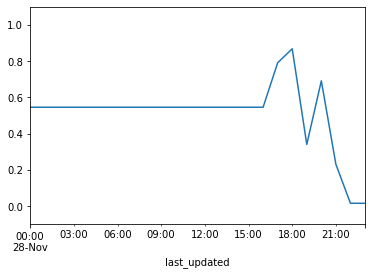

In [55]:
output[0].plot();''
plt.ylim(-.1, 1.1);